In [82]:
rna_enhancers_matrix_filtered = "10X_PBMC/enhancers_matrix_filtered.rds"
enhancer_per_celltype = c("10X_PBMC/enhancers/enhancer_per_cell_type/CD19+_enhancers.tsv",
                          "10X_PBMC/enhancers/enhancer_per_cell_type/CD20+_enhancers.tsv",
                          "10X_PBMC/enhancers/enhancer_per_cell_type/CD4+_enhancers.tsv",
                          "10X_PBMC/enhancers/enhancer_per_cell_type/CD8+_enhancers.tsv",
                          "10X_PBMC/enhancers/enhancer_per_cell_type/CD14+_enhancers.tsv",
                          "10X_PBMC/enhancers/enhancer_per_cell_type/CD14+_monocyte_enhancers.tsv",
                          "10X_PBMC/enhancers/enhancer_per_cell_type/B_cell_blood_enhancers.tsv")
enhancers_length_file = "10X_PBMC/04_count/pbmc_granulocyte_sorted_10k_counts.txt"
pbmc_rna_annotation_file = "10X_PBMC/PBMC_RNA_idents.RDS"

In [13]:
setwd(here::here()) # set working directory to project root
getwd() 

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [60]:
library(dplyr)
library(Matrix)
library(Seurat)
library(ggplot2)

In [15]:
rna_enhancers = readRDS(rna_enhancers_matrix_filtered)

In [16]:
rna_enhancers[1:10,1:10]

  [[ suppressing 10 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                               
ENSR1_C58F  . . . . . . . . . .
ENSR1_BCG8  . . . . . . . . . .
ENSR1_BDXS  . . . . . . . . . .
ENSR1_9SWG  . . . . . . . . . .
ENSR1_9TCN  . . . . . . . . . .
ENSR1_83PPN . . . . . . . . . .
ENSR1_9TCZ  . . . . . . . . . .
ENSR1_9TT9  . . . . . . . . . .
ENSR1_C7ZL  . . . . . . . . . .
ENSR1_CRHB  . . . . . . . . . .

In [110]:
enhancers_length = data.table::fread(enhancers_length_file)

In [18]:
head(enhancers_length)

Geneid,Chr,Start,End,Strand,Length,10X_PBMC/03_align/pbmc_granulocyte_sorted_10k.bam.no_XS.bam
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>
ENSR1_986,1,21129,21603,.,475,31
ENSR1_B5Q,1,25831,26342,.,512,39
ENSR1_B6N,1,31907,32843,.,937,0
ENSR1_9F7,1,38558,38851,.,294,0
ENSR1_84XG,1,137202,137378,.,177,8
ENSR1_854C,1,143914,144128,.,215,40


In [19]:
enhancers_length = enhancers_length %>% select(Geneid, Length)
head(enhancers_length)

Geneid,Length
<chr>,<int>
ENSR1_986,475
ENSR1_B5Q,512
ENSR1_B6N,937
ENSR1_9F7,294
ENSR1_84XG,177
ENSR1_854C,215


In [21]:
#normalize by length
enhancers_length_vector = enhancers_length$Length
names(enhancers_length_vector) = enhancers_length$Geneid
all_enhancers = rownames(rna_enhancers)
rna_enhancers_length_normalized <- lapply(all_enhancers, function(x){
    rna_enhancers[x, ] / enhancers_length_vector[x]
}) 


In [28]:
names(rna_enhancers_length_normalized) = all_enhancers
rna_enhancers_length_normalized = as.data.frame(rna_enhancers_length_normalized)

In [42]:
rna_enhancers_length_normalized = t(rna_enhancers_length_normalized) %>% as.data.frame()
rna_enhancers_length_normalized[1:10,1:10]

,AAACAGCCAAGGAATC,AAACAGCCAATCCCTT,AAACAGCCAATGCGCT,AAACAGCCACACTAAT,AAACAGCCACCAACCG,AAACAGCCAGGATAAC,AAACAGCCAGTAGGTG,AAACAGCCAGTTTACG,AAACAGCCATCCAGGT,AAACATGCAAGGTCCT
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSR1_C58F,0,0,0,0,0,0,0,0,0,0
ENSR1_BCG8,0,0,0,0,0,0,0,0,0,0
ENSR1_BDXS,0,0,0,0,0,0,0,0,0,0
ENSR1_9SWG,0,0,0,0,0,0,0,0,0,0
ENSR1_9TCN,0,0,0,0,0,0,0,0,0,0
ENSR1_83PPN,0,0,0,0,0,0,0,0,0,0
ENSR1_9TCZ,0,0,0,0,0,0,0,0,0,0
ENSR1_9TT9,0,0,0,0,0,0,0,0,0,0
ENSR1_C7ZL,0,0,0,0,0,0,0,0,0,0


In [56]:
# sanity check 
i = 7
cell = 5
sum_value = which(rna_enhancers_length_normalized[,cell]>0)[i]
rna_enhancers_length_normalized[sum_value,cell]
some_enhancer_name = rownames(rna_enhancers_length_normalized)[sum_value]  

rna_enhancers[some_enhancer_name,cell]
enhancers_length_vector[some_enhancer_name]

rna_enhancers[some_enhancer_name,cell] / enhancers_length_vector[some_enhancer_name]

[1] 0.001351351

[1] 1

ENSR1_BH6FW 
        740

ENSR1_BH6FW 
0.001351351

In [61]:
pbmc_erna = CreateSeuratObject(counts = rna_enhancers_length_normalized, project = "PBMC_eRNA", min.cells = 3, min.features = 3)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [62]:
pbmc_erna

An object of class Seurat 
8628 features across 11783 samples within 1 assay 
Active assay: RNA (8628 features, 0 variable features)

[1] "ENSR7-B5NCH"   "ENSR16-84M22Q" "ENSR9-7477ZS"  "ENSR3-78L2QW" 
 [5] "ENSR19-759BJM" "ENSR20-73BRG"  "ENSR5-7B5M7L"  "ENSR22-73N4DF"
 [9] "ENSR1-73W7G3"  "ENSR12-73FSJ"

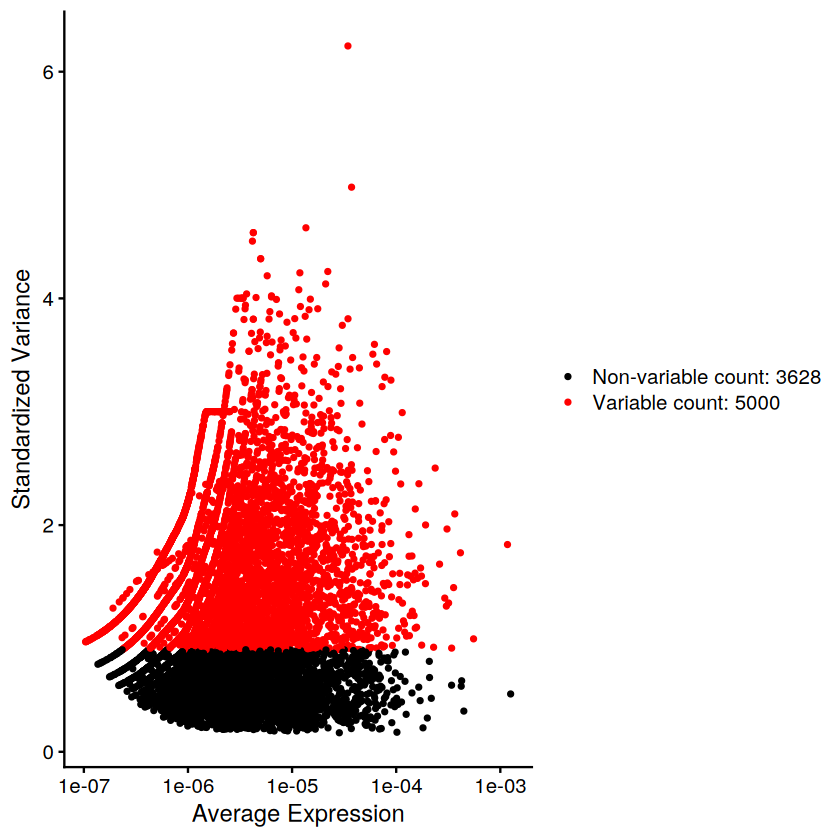

In [80]:

# Normalize and identify variable features
pbmc_erna <- NormalizeData(pbmc_erna, normalization.method = "LogNormalize", scale.factor = 1e6)
pbmc_erna <- FindVariableFeatures(pbmc_erna, selection.method = "vst", nfeatures = 5000)

# Visualize variable features
top10 <- head(VariableFeatures(pbmc_erna), 10)
top10
VariableFeaturePlot(pbmc_erna)

Centering and scaling data matrix



PC_ 1 
Positive:  ENSR12-93BL9Z, ENSR1-86FJ5Z, ENSR8-83MCR8, ENSR4-74DHLP, ENSR7-8655WP, ENSR7-934CD, ENSR4-9L4TX, ENSR3-9C8BH, ENSR16-9PZ5L, ENSR6-96HZ6 
	   ENSR4-98ZDX, ENSR16-8NXB4, ENSR6-983SW, ENSR4-8378H8, ENSR20-948JB, ENSR7-943JS6, ENSR16-8NXPF, ENSR16-937CG9, ENSR6-93L4KX, ENSR6-8G6L9 
	   ENSR5-8F87T, ENSR7-9DG8F, ENSR17-847SW5, ENSR14-84PRFX, ENSR22-993F4, ENSR14-832NFZ, ENSR4-93HQRK, ENSR17-9G9KC, ENSR21-97QQN, ENSR17-934WG6 
Negative:  ENSR6-78C72X, ENSR2-84JW6Q, ENSR16-9GKT2, ENSR6-93KRHS, ENSR4-9KXW5, ENSR18-9BNH, ENSR14-93CG5G, ENSR6-93KRHL, ENSR14-84NW86, ENSR17-9L55J 
	   ENSR4-9KXXQ, ENSR20-83PZ5P, ENSR1-94CFPK, ENSR6-855K5Q, ENSR6-838BQZ, ENSR11-85QZFN, ENSR13-9CM3S, ENSR20-9KDWH, ENSR11-93TZW6, ENSR20-9KFLZ 
	   ENSR4-9KZ4G, ENSR11-85QZPN, ENSR5-93QC73, ENSR2-8623PF, ENSR19-8FJ9D, ENSR11-85QZTD, ENSR19-99R2X, ENSR11-93TZR5, ENSR12-9654Q, ENSR5-93M8FD 
PC_ 2 
Positive:  ENSR6-78C72X, ENSR4-9KXW5, ENSR14-84NW86, ENSR16-9GKT2, ENSR3-844HCD, ENSR6-93KRHL, ENSR1-9DG3M,

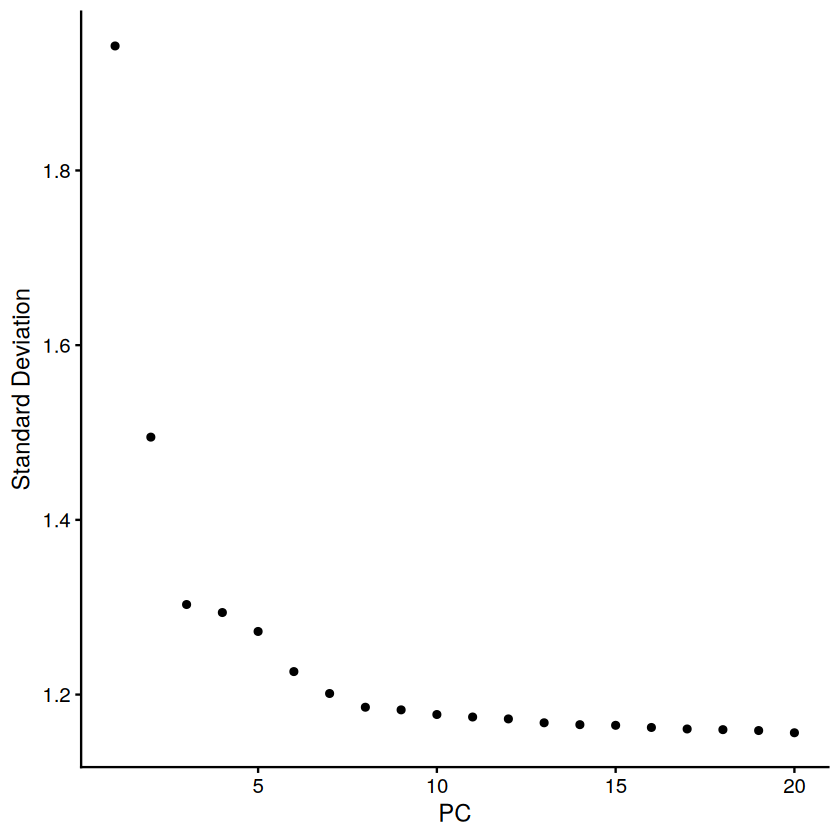

In [81]:
# Scale, PCA
pbmc_erna <- ScaleData(pbmc_erna, features = VariableFeatures(pbmc_erna))
pbmc_erna <- RunPCA(pbmc_erna, features = VariableFeatures(object = pbmc_erna))
ElbowPlot(pbmc_erna)



In [83]:
# Neighborhood graph, clustering and UMAP
pbmc_erna <- FindNeighbors(pbmc_erna, dims = 1:10)
pbmc_erna <- FindClusters(pbmc_erna, resolution = 0.2)



Computing nearest neighbor graph



Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11783
Number of edges: 314891

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8889
Number of communities: 7
Elapsed time: 2 seconds


In [84]:
pbmc_erna <- RunUMAP(pbmc_erna, dims = 1:10)

14:58:08 UMAP embedding parameters a = 0.9922 b = 1.112

14:58:08 Read 11783 rows and found 10 numeric columns

14:58:08 Using Annoy for neighbor search, n_neighbors = 30

14:58:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:58:10 Writing NN index file to temp file /tmp/RtmpAhoSYb/filea6d4e73803cb5

14:58:10 Searching Annoy index using 1 thread, search_k = 3000

14:58:14 Annoy recall = 99.58%

14:58:15 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:58:15 79 smooth knn distance failures

14:58:15 Initializing from normalized Laplacian + noise (using irlba)

14:58:16 Commencing optimization for 200 epochs, with 479528 positive edges

14:58:16 Using rng type: pcg

14:58:21 Optimization finished



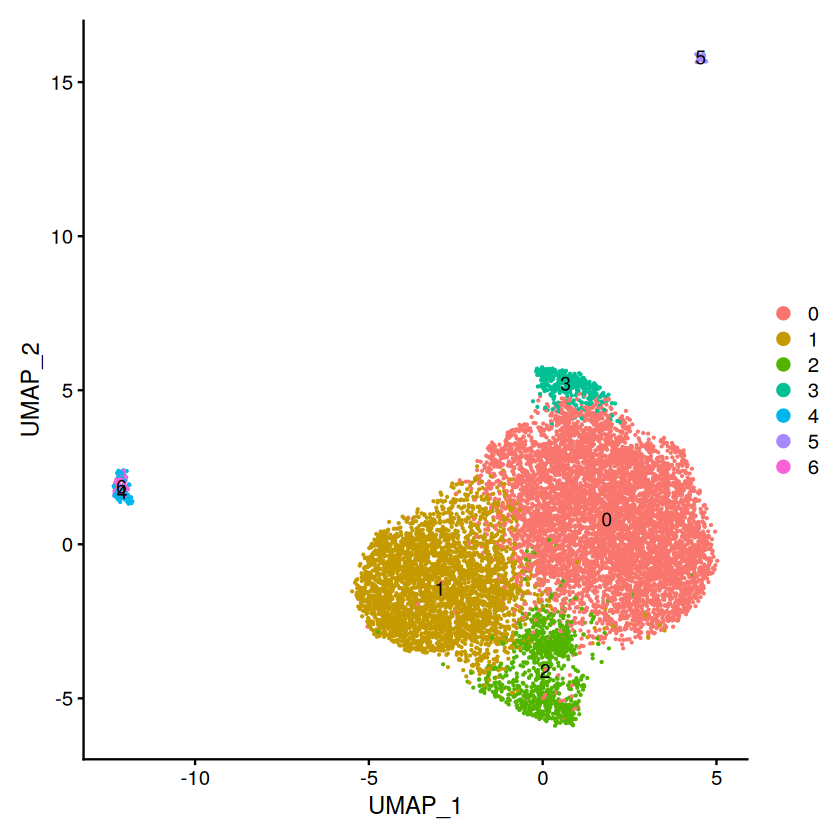

In [85]:
# Plot UMAP
DimPlot(pbmc_erna, reduction = "umap", label = TRUE)

In [90]:
cell_type_idents = readRDS(pbmc_rna_annotation_file)
rownames(cell_type_idents) = gsub("-1","",rownames(cell_type_idents))

In [92]:
pbmc_erna  = AddMetaData(object = pbmc_erna, metadata = cell_type_idents,col.name = "cell_type")

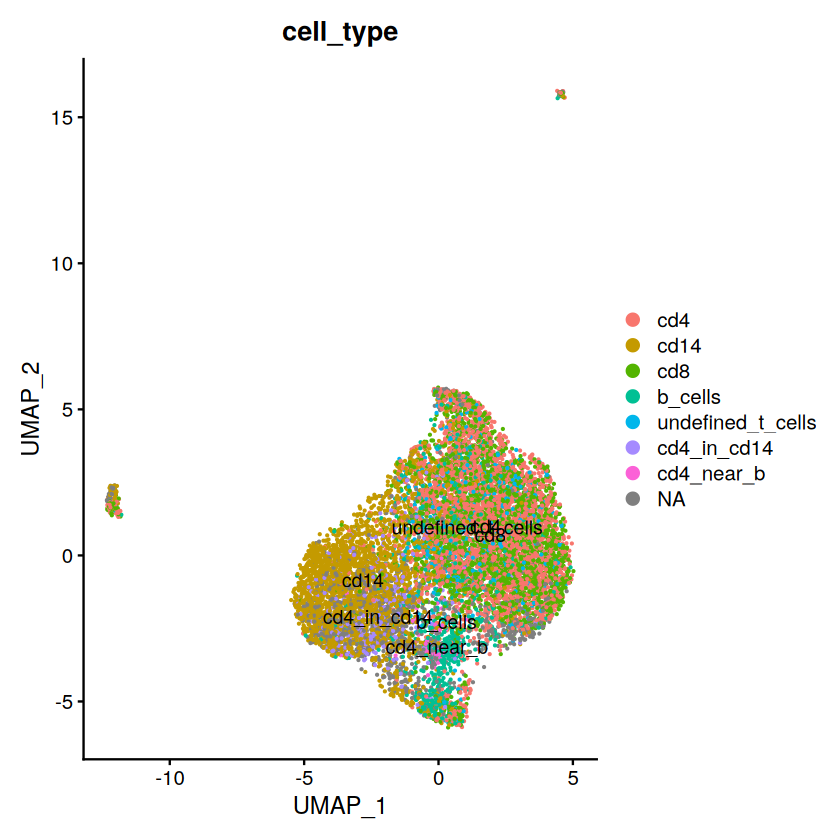

In [ ]:
DimPlot(pbmc_erna, reduction = "umap", group.by = "cell_type", label = TRUE)


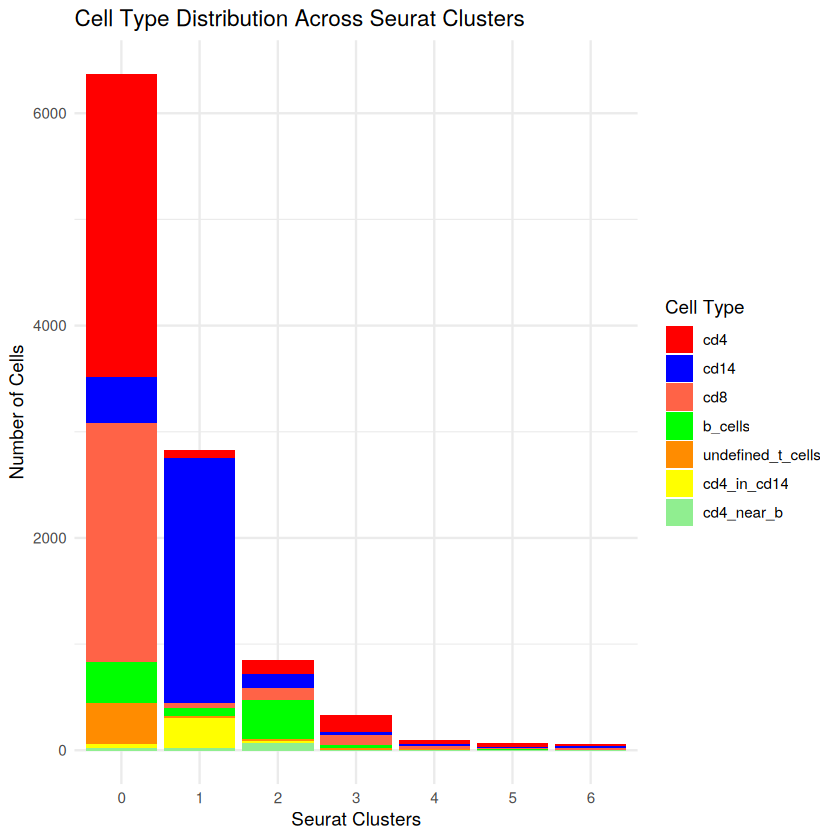

In [106]:
#stacked barplot of cell types per cluster
cluster_celltype_table = table(pbmc_erna$seurat_clusters, pbmc_erna$cell_type)
cluster_celltype_df = as.data.frame(cluster_celltype_table)

ggplot(cluster_celltype_df, aes(x=Var1, y=Freq, fill=Var2)) +
    geom_bar(stat="identity") +
    labs(x="Seurat Clusters", y="Number of Cells", fill="Cell Type") +
    ggtitle("Cell Type Distribution Across Seurat Clusters") +
    theme_minimal()+
    scale_fill_manual(values = c(
    "cd4" = "red",
    "cd8" = "tomato1",
    "undefined_t_cells" = "darkorange",
    "cd4_in_cd14" = "yellow",
    "cd4_near_b" = "lightgreen",
    "b_cells" = "green",
    "cd14" = "blue",
    "other" = "gray"  # Add other cell types here if needed
))

In [107]:
cluster_0_vs_cluster1_markers = FindMarkers(pbmc_erna, ident.1 = 0, ident.2 = 1, min.pct = 0)


For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



In [129]:
dim(cluster_0_vs_cluster1_markers)
head(cluster_0_vs_cluster1_markers,20)

[1] 7586    5

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSR5-D9GH7,0.000000e+00,-2.1710448,0.138,0.728,0.000000e+00
ENSR6-B4RN5,0.000000e+00,-2.6046050,0.047,0.383,0.000000e+00
ENSR6-B4RND,0.000000e+00,-2.4181248,0.060,0.462,0.000000e+00
ENSR12-93BL9Z,0.000000e+00,-2.5283525,0.033,0.317,0.000000e+00
ENSR10-C8T4T,5.472081e-306,-1.5323841,0.103,0.451,4.721312e-302
ENSR8-D3TQH,5.125754e-228,-2.0298307,0.036,0.253,4.422500e-224
ENSR10-D5K5S,2.094462e-215,-1.7134344,0.052,0.280,1.807102e-211
ENSR1-86FJ5Z,3.506794e-195,-3.0954547,0.011,0.166,3.025661e-191
ENSR8-83MCR8,1.140898e-183,-3.2780470,0.008,0.148,9.843668e-180


In [127]:
top_de_enhancers = rownames(head(cluster_0_vs_cluster1_markers,20)) %>% gsub("-","_",.)
enhancers_length[enhancers_length$Geneid %in% top_de_enhancers, ]

,Geneid,Chr,Start,End,Strand,Length,10X_PBMC/03_align/pbmc_granulocyte_sorted_10k.bam.no_XS.bam
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>
9668,ENSR1_86FJ5Z,1,150565701,150565927,.,227,2438
28812,ENSR2_94TT9W,2,196168942,196169414,.,473,44733
46896,ENSR4_C62P9,4,40576422,40577887,.,1466,4505
46897,ENSR4_9L4TX,4,40579993,40580386,.,394,1405
46907,ENSR4_74DHLP,4,40628435,40628558,.,124,2095
48553,ENSR4_BL6MX,4,81491836,81492531,.,696,2405
52607,ENSR4_B37GCS,4,163550195,163550895,.,701,3688
62226,ENSR5_D9GH7,5,150409625,150411996,.,2372,71459
65555,ENSR6_B4RN5,6,14121761,14122501,.,741,19213


In [128]:
#print them in format chr10:49,158,138-49,159,046
enhancers_length = as.data.frame(enhancers_length)
for(enhancer in top_de_enhancers){
    chr = enhancers_length[enhancers_length$Geneid == enhancer,"Chr"]
    start = enhancers_length[enhancers_length$Geneid == enhancer,"Start"]
    end = enhancers_length[enhancers_length$Geneid == enhancer,"End"]
    formatted_start = format(start, big.mark = ",", scientific = FALSE)
    formatted_end = format(end, big.mark = ",", scientific = FALSE)
    cat(paste0(chr, ":", formatted_start, "-", formatted_end, "\n"))
}

5:150,409,625-150,411,996
6:14,121,761-14,122,501
6:14,123,442-14,124,263
12:89,700,252-89,700,531
10:69,089,932-69,091,584
8:37,890,055-37,892,454
10:71,768,461-71,770,684
1:150,565,701-150,565,927
8:55,883,861-55,884,067
4:40,576,422-40,577,887
6:87,697,337-87,699,295
4:81,491,836-81,492,531
7:140,010,593-140,010,787
2:196,168,942-196,169,414
4:40,628,435-40,628,558
17:3,911,037-3,912,132
7:2,738,255-2,738,669
4:163,550,195-163,550,895
20:5,608,192-5,609,096
4:40,579,993-40,580,386
